In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from tqdm.auto import tqdm


c:\ProgramData\anaconda3\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060


In [3]:
data_path = 'data/low_res'
dataset = datasets.ImageFolder(root=data_path)

# Analyze class distribution
class_counts = Counter(dataset.targets)
class_names = dataset.classes
print("Class distribution:")
for idx, name in enumerate(class_names):
    print(f"{name}: {class_counts[idx]} images")

Class distribution:
Normal: 9188 images
Pneumonia: 4145 images
Tuberculosis: 1788 images


## Calculating the Normalization mean and std specifically for the dataset

In [17]:
def calculate_mean_std(dataset):

    transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

    dataset.transform = transform
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

    # Initialize tensors to store the sum of pixel values for each (RGB) channel.
    channel_sum = torch.zeros(3)
    # Initialize tensors to store the sum of squared pixel values for each channel.
    channel_sum_sq = torch.zeros(3)
    # Initialize a counter for the total number of pixels.
    num_pixels = 0

    # Wrap the loader with tqdm to create a progress bar for monitoring.
    for images, _ in tqdm(loader, desc="Calculating Dataset Stats"):
        # Add the total number of pixels in this batch to the running total.
        num_pixels += images.size(0) * images.size(2) * images.size(3)
        
        # Sum the pixel values across the batch, height, and width dimensions,
        # leaving only the channel dimension. Add this to the running total.
        channel_sum += images.sum(dim=[0, 2, 3])
        
        # Square each pixel value, then sum them up similarly to the step above.
        channel_sum_sq += (images ** 2).sum(dim=[0, 2, 3])

    # Calculate the mean for each channel.
    mean = channel_sum / num_pixels
    # Calculate the standard deviation using the formula: sqrt(E[X^2] - E[X]^2)
    std = (channel_sum_sq / num_pixels - mean ** 2) ** 0.5

    # Return the calculated mean and standard deviation.
    return mean, std

In [18]:
mean, std = calculate_mean_std(dataset)

Calculating Dataset Stats:   0%|          | 0/237 [00:00<?, ?it/s]

In [19]:
print(f"mean: {mean}")
print(f"std: {std}")

mean: tensor([0.0556, 0.0556, 0.0556])
std: tensor([0.4764, 0.4764, 0.4764])


In [87]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.0556, 0.0556, 0.0556], [0.4764, 0.4764, 0.4764])
])

In [88]:
dataset.transform = transform

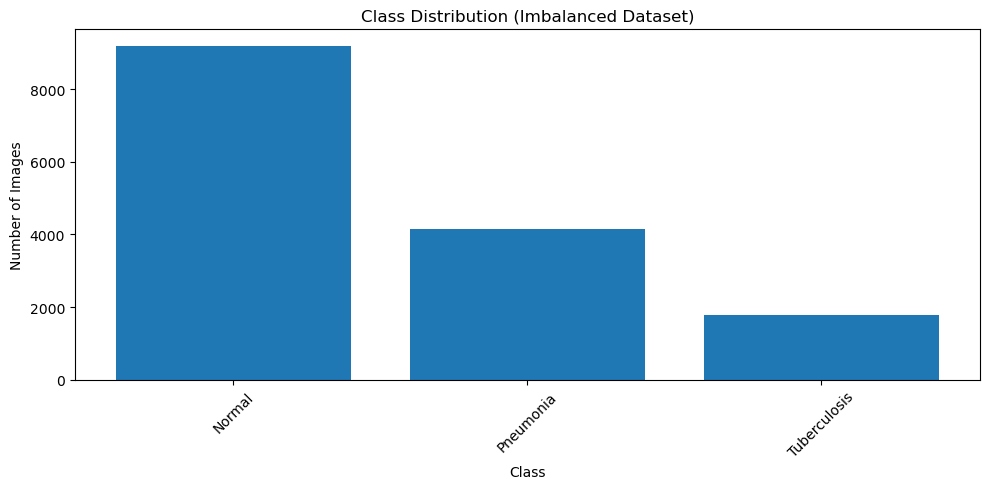

Minority class: Tuberculosis with 1788 images


In [10]:
# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_names, [class_counts[i] for i in range(len(class_names))])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution (Imbalanced Dataset)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300)
plt.show()

print(f"Minority class: Tuberculosis with 1788 images")

In [15]:
minority_class_idx = 2
minority_class_name = "Tuberculosis"

In [89]:
# Filter minority class samples
minority_indices = [i for i, label in enumerate(dataset.targets) if label == minority_class_idx]
minority_dataset = torch.utils.data.Subset(dataset, minority_indices)

# Create DataLoader for minority class
batch_size = 32
minority_loader = DataLoader(minority_dataset, batch_size=batch_size, shuffle=True)

print(f"Minority class dataset size: {len(minority_dataset)}")
print(f"Batch size: {batch_size}")

Minority class dataset size: 1788
Batch size: 32


#  Defining the Models Classes

In [91]:
# Generator
class VanillaGenerator(nn.Module):
    def __init__(self, latent_dim=100, img_size=128):
        super(VanillaGenerator, self).__init__()
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 3 * img_size * img_size),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, self.img_size, self.img_size)
        return img

# Discriminator
class VanillaDiscriminator(nn.Module):
    def __init__(self, img_size=128):
        super(VanillaDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(3 * img_size * img_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [110]:
class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3):
        super(DCGANGenerator, self).__init__()
        
        self.init_size = 4  # Initial size before upsampling
        self.l1 = nn.Linear(latent_dim, 256 * self.init_size ** 2)
        
        self.model = nn.Sequential(
            nn.BatchNorm2d(256),
            
            # (256, 4, 4) -> (128, 8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # (128, 8, 8) -> (64, 16, 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # (64, 16, 16) -> (3, 32, 32)
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        img = self.model(out)
        return img

class DCGANDiscriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(DCGANDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Input: (C, 32, 32)
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),  # -> (64, 16, 16)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # -> (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # -> (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),  # -> (1, 1, 1)
            nn.Sigmoid()
        )
    
    def forward(self, img):
        validity = self.model(img)
        return validity.view(-1, 1)

In [117]:
class CGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=3, img_channels=3):
        super(CGANGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        
        self.init_size = 8
        self.l1 = nn.Linear(latent_dim * 2, 512 * self.init_size ** 2)
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2), # 16x16

            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 128, 3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 32x32

            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat([z, label_input], -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class CGANDiscriminator(nn.Module):
    def __init__(self, num_classes=3, img_channels=3):
        super(CGANDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 32 * 32)
        
        self.model = nn.Sequential(
            nn.Conv2d(img_channels + 1, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, 2, stride=1, padding=0),
            nn.Sigmoid()
        )
    
    
    def forward(self, img, labels):
        label_input = self.label_emb(labels).view(labels.shape[0], 1, 32, 32)
        d_in = torch.cat([img, label_input], 1)
        validity = self.model(d_in)
        return validity.view(-1, 1)

In [94]:
import time
from torchvision.utils import save_image
from scipy import linalg
import numpy as np
from torchvision.models import inception_v3

# FID Score Calculation
def calculate_fid(real_images, fake_images, device):
    """Calculate Fréchet Inception Distance"""
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.fc = nn.Identity()
    inception_model.eval()
    
    def get_activations(images):
        with torch.no_grad():
            # Resize to 299x299 for Inception
            images_resized = nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            pred = inception_model(images_resized)
        return pred.cpu().numpy()
    
    act_real = get_activations(real_images)
    act_fake = get_activations(fake_images)
    
    mu_real, sigma_real = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
    mu_fake, sigma_fake = act_fake.mean(axis=0), np.cov(act_fake, rowvar=False)
    
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# Save sample images
def save_sample_images(generator, epoch, latent_dim, save_path, num_samples=25, labels=None):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        if labels is not None:
            # For CGAN
            sample_labels = torch.full((num_samples,), labels, dtype=torch.long).to(device)
            gen_imgs = generator(z, sample_labels)
        else:
            gen_imgs = generator(z)
        
        save_image(gen_imgs.data, f"{save_path}/epoch_{epoch}.png", nrow=5, normalize=True)
    generator.train()


# Defining the Training Loop for each Model

In [102]:
def train_vanilla_gan(generator, discriminator, dataloader, num_epochs=100, starting_epoch=1, latent_dim=100, 
                      save_path='generated_images/vanilla_gan', model_path='models/vanilla_gan'):
    
    os.makedirs(save_path, exist_ok=True)
    os.makedirs(model_path, exist_ok=True)
    
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    # Create metrics file
    metrics_file = f'{save_path}/training_metrics.txt'
    with open(metrics_file, 'w') as f:
        f.write("Epoch,Time(s),D_Loss,G_Loss,FID_Score\n")
    
    print(f"\n{'='*80}")
    print(f"STARTING VANILLA GAN TRAINING - {num_epochs} EPOCHS")
    print(f"{'='*80}\n")
    
    generator.train()
    discriminator.train()
    
    for epoch in range(starting_epoch, num_epochs + 1):
        epoch_start = time.time()
        epoch_d_loss = 0
        epoch_g_loss = 0
        num_batches = 0
        
        for i, (imgs, _) in enumerate(dataloader):
            batch_size = imgs.size(0)
            real_imgs = imgs.to(device)
            
            # Labels
            real_labels = torch.ones(batch_size, 1).to(device) * 0.9
            fake_labels = torch.zeros(batch_size, 1).to(device) + 0.1
            

            # Train Discriminator but skip training it every 3 epochs
            if epoch % 3 == 0:
                pass
            else:
                optimizer_D.zero_grad()
                real_discriminator_prediction = discriminator(real_imgs)
                real_loss = criterion(real_discriminator_prediction, real_labels)
                
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_imgs = generator(z)
                fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
                
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z)
            g_loss = criterion(discriminator(gen_imgs), real_labels)
            g_loss.backward()
            optimizer_G.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            num_batches += 1
        
        # Calculate average losses
        avg_d_loss = epoch_d_loss / num_batches
        avg_g_loss = epoch_g_loss / num_batches
        

        fid_score = 0.0
        if epoch % 2 == 0:
            with torch.no_grad():
                real_batch = next(iter(dataloader))[0][:64].to(device)
                z = torch.randn(64, latent_dim).to(device)
                fake_batch = generator(z)
                fid_score = calculate_fid(real_batch, fake_batch, device)
        
        epoch_time = time.time() - epoch_start
        
        # Print metrics
        print(f"Epoch {epoch} | Time: {epoch_time:.2f}s")
        print(f"  D_Loss: {avg_d_loss:.6f} | G_Loss: {avg_g_loss:.6f}")
        if epoch % 2 == 0:
            print(f"  FID Score: {fid_score:.4f}")
        print()
        
        # Save metrics to file
        with open(metrics_file, 'a') as f:
            f.write(f"{epoch},{epoch_time:.2f},{avg_d_loss:.6f},{avg_g_loss:.6f},{fid_score:.4f}\n")
        
        if epoch % 2 == 0:
            save_sample_images(generator, epoch, latent_dim, save_path)
        
        # Save model after epoch 5
        if epoch > 20 and epoch % 4 == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
            }, f"{model_path}/model_epoch_{epoch}.pt")
    
    print(f"\n{'='*80}")
    print(f"VANILLA GAN TRAINING COMPLETE")
    print(f"{'='*80}\n")
    
    return generator, discriminator


In [107]:
def train_dcgan(generator, discriminator, dataloader, starting_epoch=1, num_epochs=100, latent_dim=100,
                save_path='generated_images/dcgan', model_path='models/dcgan'):
    os.makedirs(save_path, exist_ok=True)
    os.makedirs(model_path, exist_ok=True)
    
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()
    
    metrics_file = f'{save_path}/training_metrics.txt'
    with open(metrics_file, 'w') as f:
        f.write("Epoch,Time(s),D_Loss,G_Loss,FID_Score\n")
    
    print(f"\n{'='*80}")
    print(f"STARTING DCGAN TRAINING - {num_epochs} EPOCHS")
    print(f"{'='*80}\n")
    
    generator.train()
    discriminator.train()
    
    for epoch in range(starting_epoch, num_epochs + 1):
        epoch_start = time.time()
        epoch_d_loss = 0
        epoch_g_loss = 0
        num_batches = 0
        
        for i, (imgs, _) in enumerate(dataloader):
            batch_size = imgs.size(0)
            real_imgs = imgs.to(device)
            
            real_labels = torch.ones(batch_size, 1).to(device) * 0.9
            fake_labels = torch.zeros(batch_size, 1).to(device) + 0.1
            
            # Train Discriminator but skip training it every 3 epochs
            if epoch % 3 == 0:
                pass
            else:
                optimizer_D.zero_grad()
                real_loss = criterion(discriminator(real_imgs), real_labels)
                
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_imgs = generator(z)
                fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
                
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z)
            g_loss = criterion(discriminator(gen_imgs), real_labels)
            g_loss.backward()
            optimizer_G.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            num_batches += 1
        
        avg_d_loss = epoch_d_loss / num_batches
        avg_g_loss = epoch_g_loss / num_batches
        
        # Calculate FID every 2 epochs
        fid_score = 0.0
        if epoch % 2 == 0:
            with torch.no_grad():
                real_batch = next(iter(dataloader))[0][:64].to(device)
                z = torch.randn(64, latent_dim).to(device)
                fake_batch = generator(z)
                fid_score = calculate_fid(real_batch, fake_batch, device)
        
        epoch_time = time.time() - epoch_start
        
        print(f"Epoch {epoch} | Time: {epoch_time:.2f}s")
        print(f"  D_Loss: {avg_d_loss:.6f} | G_Loss: {avg_g_loss:.6f}")
        if epoch % 2 == 0:
            print(f"  FID Score: {fid_score:.4f}")
        print()
        
        with open(metrics_file, 'a') as f:
            f.write(f"{epoch},{epoch_time:.2f},{avg_d_loss:.6f},{avg_g_loss:.6f},{fid_score:.4f}\n")
        
        if epoch % 2 == 0:
            save_sample_images(generator, epoch, latent_dim, save_path)
        
        if epoch > 20 and epoch % 4 == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
            }, f"{model_path}/model_epoch_{epoch}.pt")
    
    print(f"\n{'='*80}")
    print(f"DCGAN TRAINING COMPLETE")
    print(f"{'='*80}\n")
    
    return generator, discriminator


In [100]:
def train_cgan(generator, discriminator, dataloader, minority_class_idx, num_epochs=100, starting_epoch=1, 
               latent_dim=100, save_path='generated_images/cgan', model_path='models/cgan'):
    

    os.makedirs(save_path, exist_ok=True)
    os.makedirs(model_path, exist_ok=True)

    optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()
    
    metrics_file = f'{save_path}/training_metrics.txt'
    with open(metrics_file, 'w') as f:
        f.write("Epoch,Time(s),D_Loss,G_Loss,FID_Score\n")
    
    print(f"\n{'='*80}")
    print(f"STARTING CGAN TRAINING - {num_epochs} EPOCHS")
    print(f"{'='*80}\n")
    
    generator.train()
    discriminator.train()
    
    for epoch in range(starting_epoch, num_epochs + 1):
        epoch_start = time.time()
        epoch_d_loss = 0
        epoch_g_loss = 0
        num_batches = 0
        
        for i, (imgs, labels) in enumerate(dataloader):
            batch_size = imgs.size(0)
            real_imgs = imgs.to(device)
            labels = labels.to(device)
            
            real_labels = torch.ones(batch_size, 1).to(device) * 0.9
            fake_labels = torch.zeros(batch_size, 1).to(device) + 0.1
            
            # Train Discriminator but skip training it every 3 epochs
            if epoch % 3 == 0:
                pass
            else:
                optimizer_D.zero_grad()
                real_loss = criterion(discriminator(real_imgs, labels), real_labels)
                
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_imgs = generator(z, labels)
                fake_loss = criterion(discriminator(fake_imgs.detach(), labels), fake_labels)
                
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z, labels)
            g_loss = criterion(discriminator(gen_imgs, labels), real_labels)
            g_loss.backward()
            optimizer_G.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            num_batches += 1
        
        avg_d_loss = epoch_d_loss / num_batches
        avg_g_loss = epoch_g_loss / num_batches
        
        # Calculate FID every 2 epochs
        fid_score = 0.0
        if epoch % 2 == 0:
            with torch.no_grad():
                real_batch = next(iter(dataloader))[0][:64].to(device)
                z = torch.randn(64, latent_dim).to(device)
                sample_labels = torch.full((64,), minority_class_idx, dtype=torch.long).to(device)
                fake_batch = generator(z, sample_labels)
                fid_score = calculate_fid(real_batch, fake_batch, device)
        
        epoch_time = time.time() - epoch_start
        
        print(f"Epoch {epoch} | Time: {epoch_time:.2f}s")
        print(f"  D_Loss: {avg_d_loss:.6f} | G_Loss: {avg_g_loss:.6f}")
        if epoch % 2 == 0:
            print(f"  FID Score: {fid_score:.4f}")
        print()
        
        with open(metrics_file, 'a') as f:
            f.write(f"{epoch},{epoch_time:.2f},{avg_d_loss:.6f},{avg_g_loss:.6f},{fid_score:.4f}\n")
        
        if epoch % 2 == 0:
            save_sample_images(generator, epoch, latent_dim, save_path, labels=minority_class_idx)
        
        if epoch > 20 and epoch % 4 == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
            }, f"{model_path}/model_epoch_{epoch}.pt")
    
    print(f"\n{'='*80}")
    print(f"CGAN TRAINING COMPLETE")
    print(f"{'='*80}\n")
    
    return generator, discriminator

**Training Vanilla GAN**

In [99]:
# Set random seed for reproducibility
torch.manual_seed(42)
latent_dim = 100

# Initialize models
vanilla_gen = VanillaGenerator(latent_dim=latent_dim, img_size=32).to(device)
vanilla_disc = VanillaDiscriminator(img_size=32).to(device)

print(f"Vanilla Generator parameters: {sum(p.numel() for p in vanilla_gen.parameters()):,}")
print(f"Vanilla Discriminator parameters: {sum(p.numel() for p in vanilla_disc.parameters()):,}")

Vanilla Generator parameters: 3,834,624
Vanilla Discriminator parameters: 3,803,137


In [103]:
# Train Vanilla GAN
num_epochs = 100
vanilla_gen, vanilla_disc = train_vanilla_gan(
    vanilla_gen, 
    vanilla_disc, 
    minority_loader, 
    num_epochs=num_epochs,
    latent_dim=latent_dim,
    save_path='generated_images/vanilla_gan',
    model_path='models/vanilla_gan'
)


STARTING VANILLA GAN TRAINING - 100 EPOCHS

Epoch 1 | Time: 2.83s
  D_Loss: 0.563648 | G_Loss: 0.772670



c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\mamou\AppData\Local\Temp\ipykernel_31756\2722015332.py:28: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
C:\Users\mamou\AppData\Local\Temp\ipykernel_31756\2722015332.py:28: LinAlgWarning: Matrix is singular. The result might be inaccurate or

Epoch 2 | Time: 11.49s
  D_Loss: 0.623294 | G_Loss: 0.651922
  FID Score: 363.4728

Epoch 3 | Time: 2.02s
  D_Loss: 0.608301 | G_Loss: 0.448395

Epoch 4 | Time: 11.66s
  D_Loss: 0.672562 | G_Loss: 0.718628
  FID Score: 341.4000

Epoch 5 | Time: 2.03s
  D_Loss: 0.654959 | G_Loss: 0.634269

Epoch 6 | Time: 15.39s
  D_Loss: 0.636603 | G_Loss: 0.460647
  FID Score: 290.8119

Epoch 7 | Time: 2.40s
  D_Loss: 0.655099 | G_Loss: 0.708532

Epoch 8 | Time: 12.58s
  D_Loss: 0.648440 | G_Loss: 0.688142
  FID Score: 298.1932

Epoch 9 | Time: 1.80s
  D_Loss: 0.740177 | G_Loss: 0.499555

Epoch 10 | Time: 15.00s
  D_Loss: 0.632151 | G_Loss: 0.844523
  FID Score: 299.8883

Epoch 11 | Time: 2.06s
  D_Loss: 0.637239 | G_Loss: 0.702686

Epoch 12 | Time: 17.26s
  D_Loss: 0.609468 | G_Loss: 0.483476
  FID Score: 275.7558

Epoch 13 | Time: 2.08s
  D_Loss: 0.632367 | G_Loss: 0.760033

Epoch 14 | Time: 16.02s
  D_Loss: 0.619213 | G_Loss: 0.748934
  FID Score: 274.6268

Epoch 15 | Time: 1.81s
  D_Loss: 0.564475

The best Epoch is 70

**Training DCGAN GAN**

In [111]:
# Initialize DCGAN
dcgan_gen = DCGANGenerator(latent_dim=latent_dim).to(device)
dcgan_disc = DCGANDiscriminator().to(device)

print(f"\nDCGAN Generator parameters: {sum(p.numel() for p in dcgan_gen.parameters()):,}")
print(f"DCGAN Discriminator parameters: {sum(p.numel() for p in dcgan_disc.parameters()):,}")


DCGAN Generator parameters: 1,073,219
DCGAN Discriminator parameters: 663,745


In [112]:
dcgan_gen, dcgan_disc = train_dcgan(
    dcgan_gen,
    dcgan_disc,
    minority_loader,
    num_epochs=num_epochs,
    latent_dim=latent_dim,
)


STARTING DCGAN TRAINING - 100 EPOCHS

Epoch 1 | Time: 2.30s
  D_Loss: 0.343217 | G_Loss: 2.137417



C:\Users\mamou\AppData\Local\Temp\ipykernel_31756\2722015332.py:28: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
C:\Users\mamou\AppData\Local\Temp\ipykernel_31756\2722015332.py:28: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)


Epoch 2 | Time: 12.59s
  D_Loss: 0.336926 | G_Loss: 2.260074
  FID Score: 396.4155

Epoch 3 | Time: 2.05s
  D_Loss: 0.331577 | G_Loss: 0.612319

Epoch 4 | Time: 16.46s
  D_Loss: 0.382754 | G_Loss: 2.212358
  FID Score: 332.5704

Epoch 5 | Time: 2.36s
  D_Loss: 0.340544 | G_Loss: 2.161172

Epoch 6 | Time: 14.85s
  D_Loss: 0.344709 | G_Loss: 0.696294
  FID Score: 337.6371

Epoch 7 | Time: 2.41s
  D_Loss: 0.410165 | G_Loss: 2.066207

Epoch 8 | Time: 15.81s
  D_Loss: 0.338833 | G_Loss: 2.141226
  FID Score: 358.2674

Epoch 9 | Time: 1.88s
  D_Loss: 0.331256 | G_Loss: 0.854641

Epoch 10 | Time: 15.98s
  D_Loss: 0.391039 | G_Loss: 2.178513
  FID Score: 336.2652

Epoch 11 | Time: 2.42s
  D_Loss: 0.331997 | G_Loss: 2.129127

Epoch 12 | Time: 12.75s
  D_Loss: 0.335409 | G_Loss: 1.297927
  FID Score: 345.8259

Epoch 13 | Time: 2.43s
  D_Loss: 0.366114 | G_Loss: 2.180859

Epoch 14 | Time: 12.10s
  D_Loss: 0.333842 | G_Loss: 2.114694
  FID Score: 303.4907

Epoch 15 | Time: 1.94s
  D_Loss: 0.362843

epoch 44 is the best

**Training CGAN GAN**

In [119]:
# Initialize CGAN
num_classes = len(class_names)
cgan_gen = CGANGenerator(latent_dim=latent_dim, num_classes=num_classes).to(device)
cgan_disc = CGANDiscriminator(num_classes=num_classes).to(device)

print(f"\nCGAN Generator parameters: {sum(p.numel() for p in cgan_gen.parameters()):,}")
print(f"CGAN Discriminator parameters: {sum(p.numel() for p in cgan_disc.parameters()):,}")


CGAN Generator parameters: 8,139,055
CGAN Discriminator parameters: 2,764,481


In [123]:
cgan_gen, cgan_disc = train_cgan(
    cgan_gen,
    cgan_disc,
    minority_loader,
    minority_class_idx,
    num_epochs=num_epochs,
    latent_dim=latent_dim,
)


STARTING CGAN TRAINING - 100 EPOCHS

Epoch 1 | Time: 3.04s
  D_Loss: 0.376349 | G_Loss: 2.331968



C:\Users\mamou\AppData\Local\Temp\ipykernel_31756\2722015332.py:28: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
C:\Users\mamou\AppData\Local\Temp\ipykernel_31756\2722015332.py:28: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)


Epoch 2 | Time: 13.63s
  D_Loss: 0.333416 | G_Loss: 2.195502
  FID Score: 409.1740

Epoch 3 | Time: 2.62s
  D_Loss: 0.349897 | G_Loss: 1.647663

Epoch 4 | Time: 14.15s
  D_Loss: 0.382518 | G_Loss: 2.276863
  FID Score: 383.0750

Epoch 5 | Time: 4.81s
  D_Loss: 0.335652 | G_Loss: 2.134740

Epoch 6 | Time: 13.84s
  D_Loss: 0.453542 | G_Loss: 0.378009
  FID Score: 399.9601

Epoch 7 | Time: 3.17s
  D_Loss: 0.439584 | G_Loss: 1.988269

Epoch 8 | Time: 13.52s
  D_Loss: 0.327505 | G_Loss: 2.062441
  FID Score: 388.2015

Epoch 9 | Time: 2.93s
  D_Loss: 0.325385 | G_Loss: 1.027799

Epoch 10 | Time: 14.22s
  D_Loss: 0.387209 | G_Loss: 1.998247
  FID Score: 397.3696

Epoch 11 | Time: 3.29s
  D_Loss: 0.328229 | G_Loss: 2.075007

Epoch 12 | Time: 14.32s
  D_Loss: 0.327045 | G_Loss: 1.502221
  FID Score: 436.4069

Epoch 13 | Time: 3.23s
  D_Loss: 0.345077 | G_Loss: 2.097829

Epoch 14 | Time: 14.28s
  D_Loss: 0.326540 | G_Loss: 2.071369
  FID Score: 413.4449

Epoch 15 | Time: 2.70s
  D_Loss: 0.327266

Looking at the images the best epoch is 22

In [124]:
gc.collect()
torch.cuda.empty_cache()

In [125]:
import os
from torchvision.utils import save_image
from PIL import Image

# Create directories for synthetic images
os.makedirs('synthetic_data/vanilla_gan', exist_ok=True)
os.makedirs('synthetic_data/dcgan', exist_ok=True)
os.makedirs('synthetic_data/cgan', exist_ok=True)

print("Created directories for synthetic images")

Created directories for synthetic images


In [127]:
latent_dim = 100

# Load Vanilla GAN 
vanilla_gen = VanillaGenerator(latent_dim=latent_dim, img_size=32).to(device)
checkpoint_vanilla = torch.load('models/vanilla_gan/model_epoch_44.pt')
vanilla_gen.load_state_dict(checkpoint_vanilla['generator_state_dict'])
vanilla_gen.eval()
print("✓ Loaded Vanilla GAN from epoch 44")

# Load DCGAN 
dcgan_gen = DCGANGenerator(latent_dim=latent_dim, img_channels=3).to(device)
checkpoint_dcgan = torch.load('models/dcgan/model_epoch_44.pt')
dcgan_gen.load_state_dict(checkpoint_dcgan['generator_state_dict'])
dcgan_gen.eval()
print("✓ Loaded DCGAN from epoch 44")

# Load CGAN 
num_classes = 3
cgan_gen = CGANGenerator(latent_dim=latent_dim, num_classes=num_classes, img_channels=3).to(device)
checkpoint_cgan = torch.load('models/cgan/model_epoch_92.pt')
cgan_gen.load_state_dict(checkpoint_cgan['generator_state_dict'])
cgan_gen.eval()
print("✓ Loaded CGAN from epoch 92")

C:\Users\mamou\AppData\Local\Temp\ipykernel_31756\2923563320.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_vanilla = torch.load('models/vanilla_gan/model_ep

✓ Loaded Vanilla GAN from epoch 44
✓ Loaded DCGAN from epoch 44


C:\Users\mamou\AppData\Local\Temp\ipykernel_31756\2923563320.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dcgan = torch.load('models/dcgan/model_epoch_44.

✓ Loaded CGAN from epoch 92


In [131]:
def generate_synthetic_images(generator, num_images, save_dir, gan_type='vanilla', minority_class_idx=None):
    """
    Generate synthetic images and save them individually
    
    Args:
        generator: trained generator model
        num_images: number of images to generate
        save_dir: directory to save images
        gan_type: 'vanilla', 'dcgan', or 'cgan'
        minority_class_idx: class index for CGAN
    """
    generator.eval()
    batch_size = 64  # Generate in batches to avoid memory issues
    num_batches = (num_images + batch_size - 1) // batch_size
    
    print(f"\n{'='*60}")
    print(f"Generating {num_images} images for {gan_type.upper()}")
    print(f"{'='*60}")
    
    img_count = 0
    
    with torch.no_grad():
        for batch_idx in range(num_batches):
            # Calculate batch size for last batch
            current_batch_size = min(batch_size, num_images - img_count)
            
            # Generate noise
            z = torch.randn(current_batch_size, latent_dim).to(device)
            
            # Generate images
            if gan_type == 'cgan':
                labels = torch.full((current_batch_size,), minority_class_idx, dtype=torch.long).to(device)
                fake_imgs = generator(z, labels)
            else:
                fake_imgs = generator(z)
            
            # Save each image individually
            for i in range(current_batch_size):
                img = fake_imgs[i]
                # Denormalize from [-1, 1] to [0, 1]
                img = (img + 1) / 2
                img = torch.clamp(img, 0, 1)
                
                # Save image
                img_path = os.path.join(save_dir, f'synthetic_{img_count:05d}.png')
                save_image(img, img_path)
                img_count += 1
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Generated {img_count}/{num_images} images...")
    
    print(f"✓ Complete! Generated {img_count} images in {save_dir}")
    return img_count

In [132]:
num_synthetic = 7400

# Generate for Vanilla GAN
count_vanilla = generate_synthetic_images(
    vanilla_gen, 
    num_synthetic, 
    'synthetic_data/vanilla_gan',
    gan_type='vanilla'
)

# Generate for DCGAN
count_dcgan = generate_synthetic_images(
    dcgan_gen,
    num_synthetic,
    'synthetic_data/dcgan',
    gan_type='dcgan'
)

# Generate for CGAN (class 2 = Tuberculosis)
count_cgan = generate_synthetic_images(
    cgan_gen,
    num_synthetic,
    'synthetic_data/cgan',
    gan_type='cgan',
    minority_class_idx=minority_class_idx
)

print(f"\n{'='*60}")
print(f"GENERATION SUMMARY")
print(f"{'='*60}")
print(f"Vanilla GAN: {count_vanilla} images")
print(f"DCGAN: {count_dcgan} images")
print(f"CGAN: {count_cgan} images")
print(f"Total synthetic images: {count_vanilla + count_dcgan + count_cgan}")


Generating 7400 images for VANILLA
Generated 640/7400 images...
Generated 1280/7400 images...
Generated 1920/7400 images...
Generated 2560/7400 images...
Generated 3200/7400 images...
Generated 3840/7400 images...
Generated 4480/7400 images...
Generated 5120/7400 images...
Generated 5760/7400 images...
Generated 6400/7400 images...
Generated 7040/7400 images...
✓ Complete! Generated 7400 images in synthetic_data/vanilla_gan

Generating 7400 images for DCGAN
Generated 640/7400 images...
Generated 1280/7400 images...
Generated 1920/7400 images...
Generated 2560/7400 images...
Generated 3200/7400 images...
Generated 3840/7400 images...
Generated 4480/7400 images...
Generated 5120/7400 images...
Generated 5760/7400 images...
Generated 6400/7400 images...
Generated 7040/7400 images...
✓ Complete! Generated 7400 images in synthetic_data/dcgan

Generating 7400 images for CGAN
Generated 640/7400 images...
Generated 1280/7400 images...
Generated 1920/7400 images...
Generated 2560/7400 images..